In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import mne
import matplotlib.pyplot as plt
import os

In [2]:
raw_data_dir = './data/'
processed_data_dir = './data_processed/'

all_files = []
for _dir in os.listdir(raw_data_dir):
    sub_dir = os.path.join(raw_data_dir, _dir)
    if os.path.isdir(sub_dir):
        for file in os.listdir(sub_dir):
            edf_file_path = os.path.join(sub_dir, file)
            all_files = all_files + [edf_file_path]

In [3]:
i=13

In [4]:
edf_file_path = all_files[i]
raw = mne.io.read_raw_edf(edf_file_path, preload=True)
raw_temp = raw.copy()
raw_segment = raw_temp.crop(tmin=60, tmax=160)
raw.notch_filter(freqs=50)
raw.filter(l_freq=0.5, h_freq=50, method='iir')
valid_channel_names = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE',
                        'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE',
                        'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE']
raw.pick(valid_channel_names)
channel_mapping = {
    'EEG Fp1-LE': 'Fp1', 'EEG F3-LE': 'F3', 'EEG C3-LE': 'C3', 'EEG P3-LE': 'P3', 'EEG O1-LE': 'O1',
    'EEG F7-LE': 'F7', 'EEG T3-LE': 'T3', 'EEG T5-LE': 'T5', 'EEG Fz-LE': 'Fz', 'EEG Fp2-LE': 'Fp2',
    'EEG F4-LE': 'F4', 'EEG C4-LE': 'C4', 'EEG P4-LE': 'P4', 'EEG O2-LE': 'O2', 'EEG F8-LE': 'F8',
    'EEG T4-LE': 'T4', 'EEG T6-LE': 'T6', 'EEG Cz-LE': 'Cz', 'EEG Pz-LE': 'Pz',
}
raw.rename_channels(channel_mapping)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

Extracting EDF parameters from f:\脑电\EEG论文\论文复现\data\H\H S22 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter or

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawEDF | H S22 EO.edf, 19 x 76544 (299.0 s), ~11.1 MiB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 19 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.


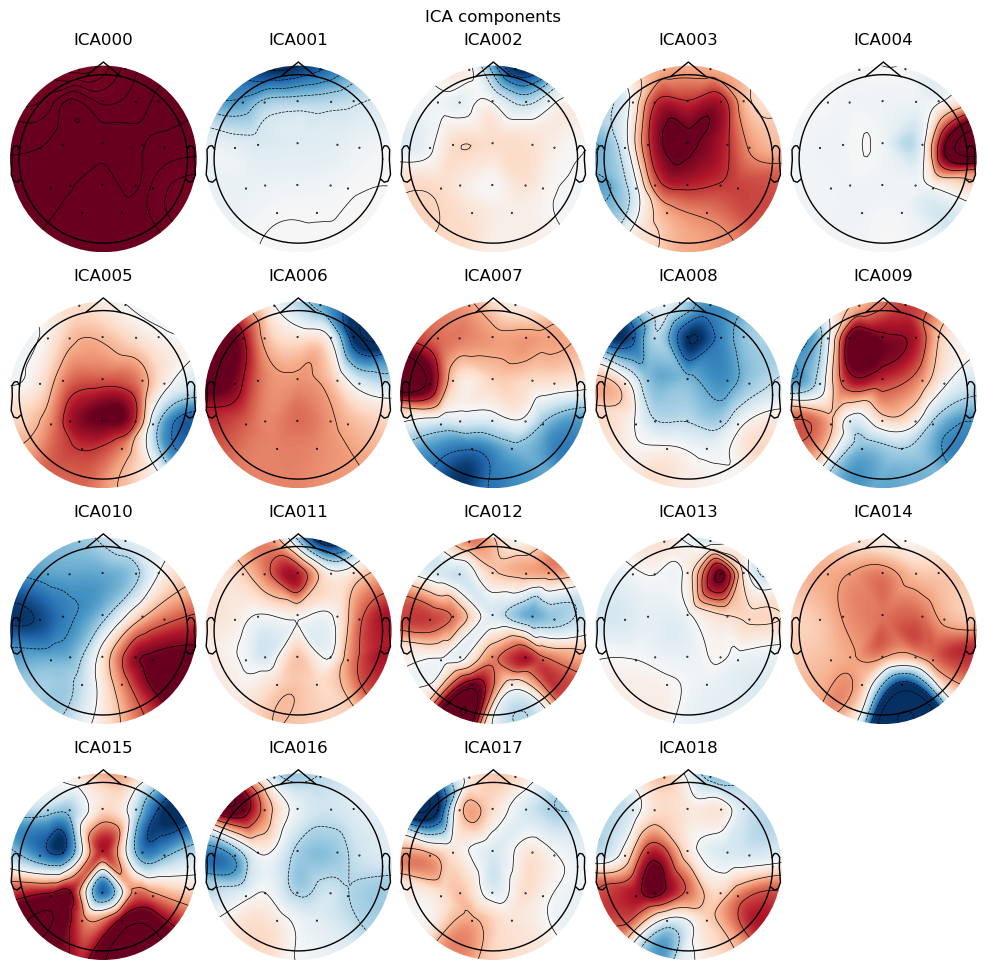

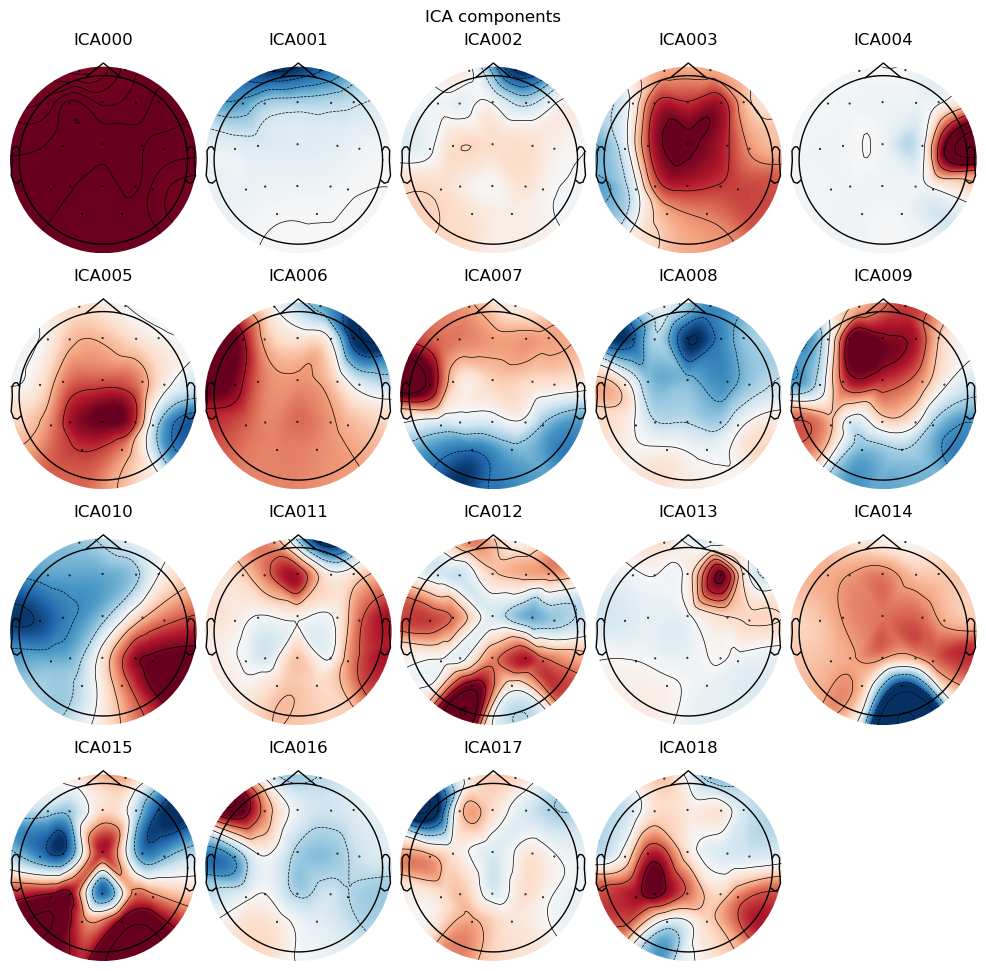

In [5]:
ica = mne.preprocessing.ICA(max_iter='auto', random_state=97)
raw_for_ica = raw.copy().filter(l_freq=1, h_freq=None)
ica.fit(raw_for_ica)
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated


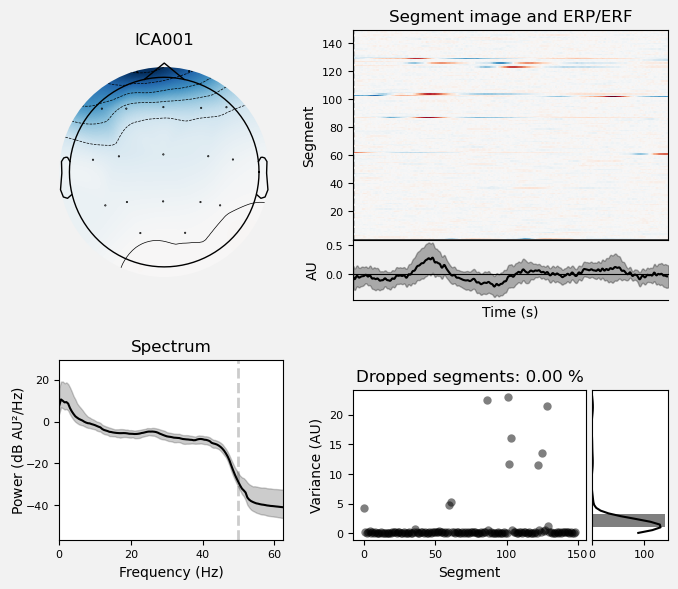

[<Figure size 700x600 with 6 Axes>]

In [6]:
ica.plot_properties(raw, picks=[1])

Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
Creating RawArray with float64 data, n_channels=19, n_times=76544
    Range : 0 ... 76543 =      0.000 ...   298.996 secs
Ready.
Using matplotlib as 2D backend.


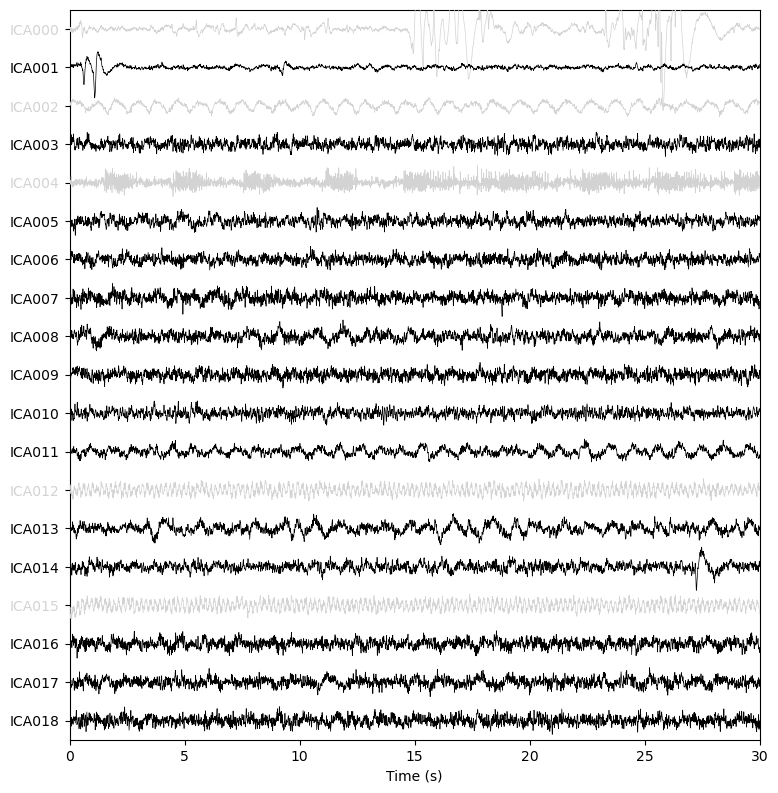

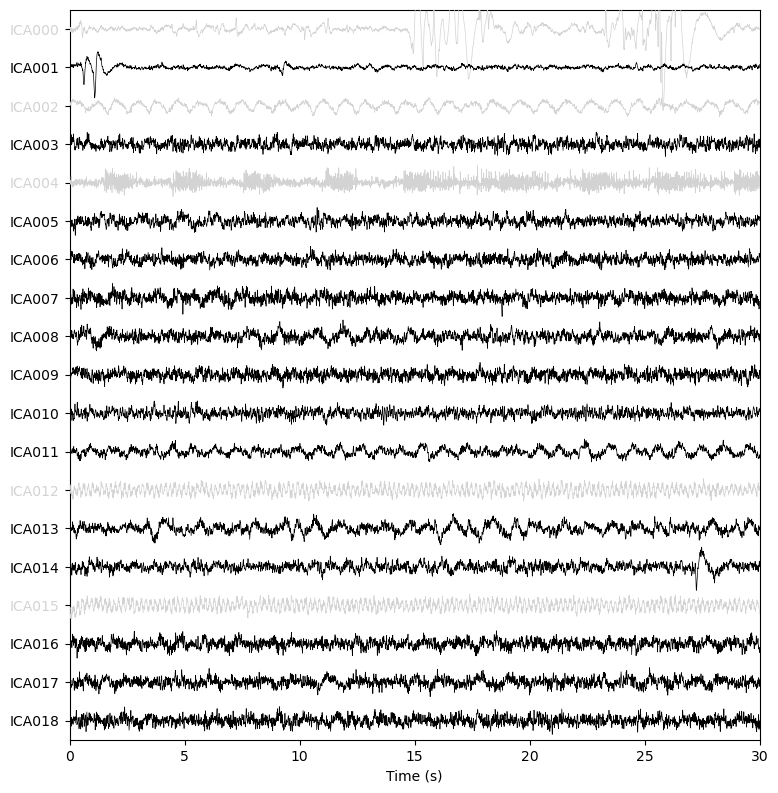

In [7]:
ica.exclude = [0,2,4,12,15]
raw_clean = ica.apply(raw_for_ica)
ica.plot_sources(raw, start=0, stop=30, show_scrollbars=False)

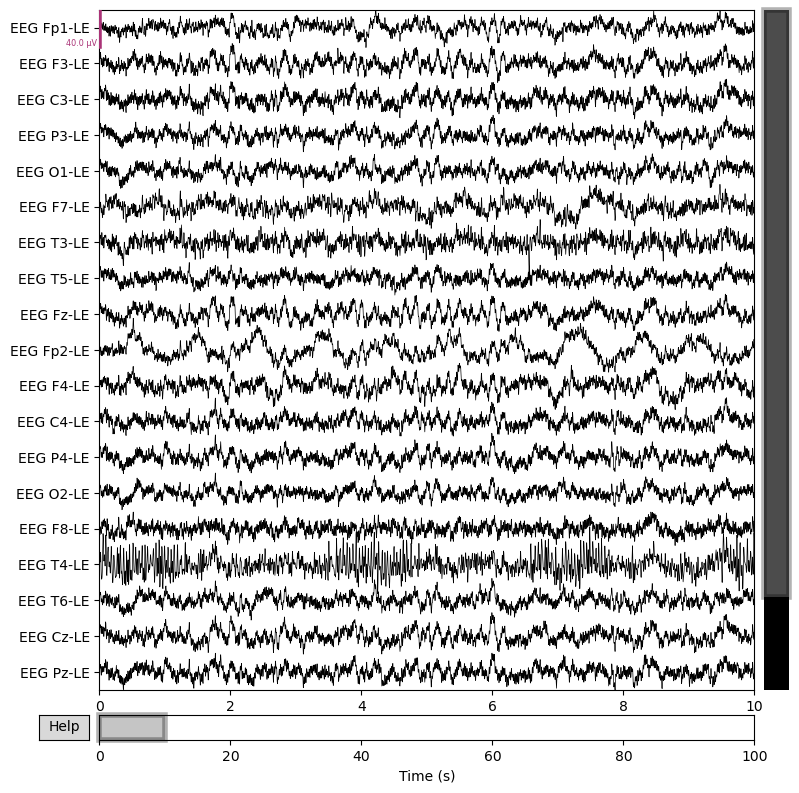

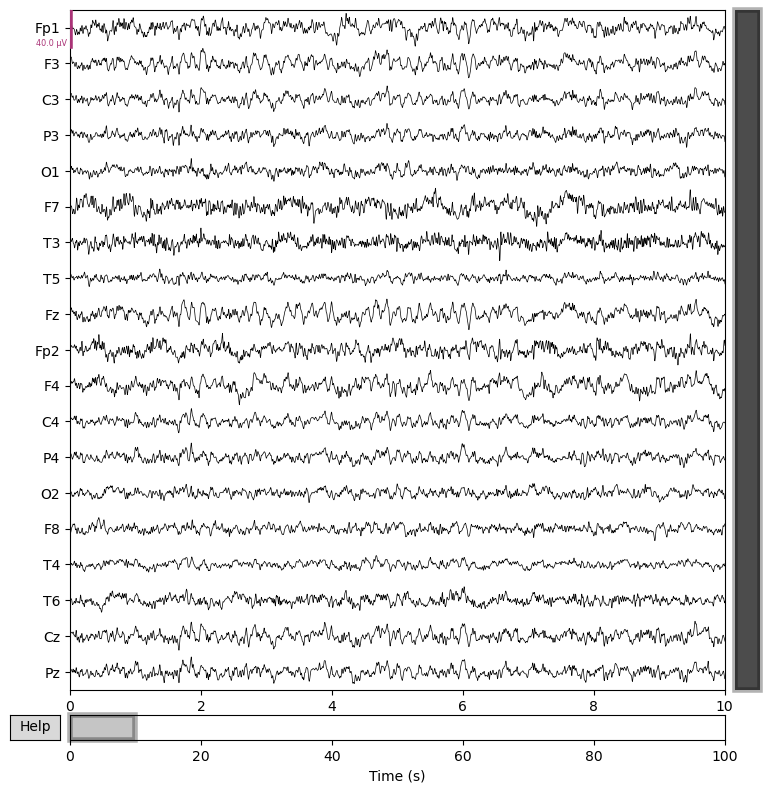

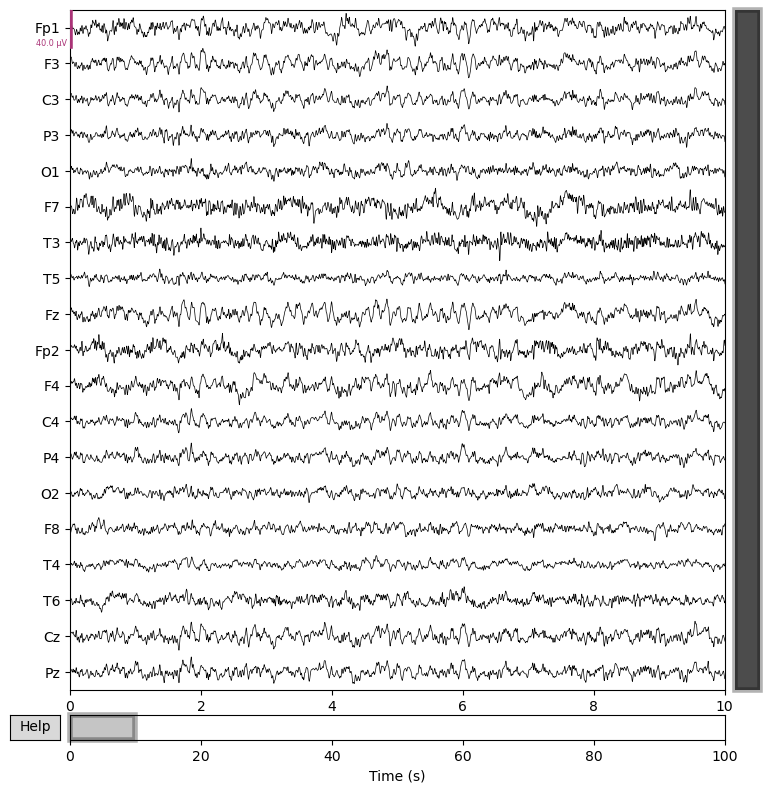

In [8]:
# raw_clean.set_eeg_reference('average', projection=False)
raw_clean_temp = raw_clean.copy()
raw_clean_segment = raw_clean_temp.crop(tmin=60, tmax=160)

raw_segment.plot(duration=10, n_channels=19, title='Raw EEG Data')
raw_clean_segment.plot(duration=10, n_channels=19, title='Raw EEG Data')

In [9]:
# print(f"'{edf_file_path}':{ica.exclude}")